## PaySim Dataset

##### <b>step</b> - integer - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

##### <b>type</b> - string/categorical - type of transaction: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

##### <b>amount</b> - float - amount of the transaction in local currency.

##### <b>nameOrig</b> - string - customer who initiated the transaction

##### <b>oldbalanceOrg</b> - float initial balance before the transaction

##### <b>newbalanceOrig</b> - float - new balance after the transaction

##### <b>nameDest</b> - string - customer who is the recipient of the transaction

##### <b>oldbalanceDest</b> - float - initial balance of recipient before the transaction.

##### <b>newbalanceDest</b> - float - new balance of recipient after the transaction.

##### <b>fraud</b> - boolean/binary - determines if transaction is fraudulent (encoded as 1) or valid (encoded as 0)

##### <b>flaggedFraud</b> - boolean/binary - determines if transaction is flagged as fraudulent (encoded as 1) or not flagged at all (encoded as 0). An observation is flagged if the transaction is fraudulent and it involved a transfer of over 200,000 in the local currency.

In [1]:
spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log
3,application_1597932034633_0009,pyspark,idle,Link,Link


SparkSession available as 'spark'.

In [2]:
from pyspark.sql import functions as func

In [3]:
df = spark.read.load("hdfs:///Projects/paysim/paysim_Training_Datasets/PaySim/paysim_Q1.parquet") 

In [5]:
df = df.withColumn("label", func.when(func.col("fraud") == "true", 1 ).otherwise(0))

In [6]:
df.count()

3300968

In [7]:
df.where(func.col("label")==1).count()

1434

In [12]:
action_counts = df.select('label','action').groupBy('label','action').agg(func.count('action').alias("value_counts"))
fraud_action_counts = action_counts.where(func.col('label') == 1)
valid_action_counts = action_counts.where(func.col('label') == 0)

In [13]:
%%spark -o fraud_action_counts

In [14]:
%%spark -o valid_action_counts

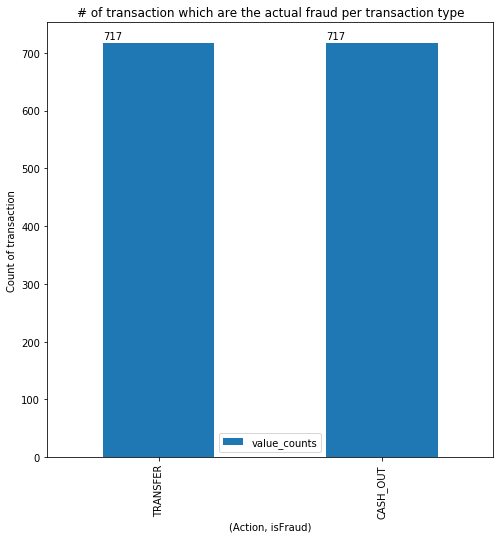

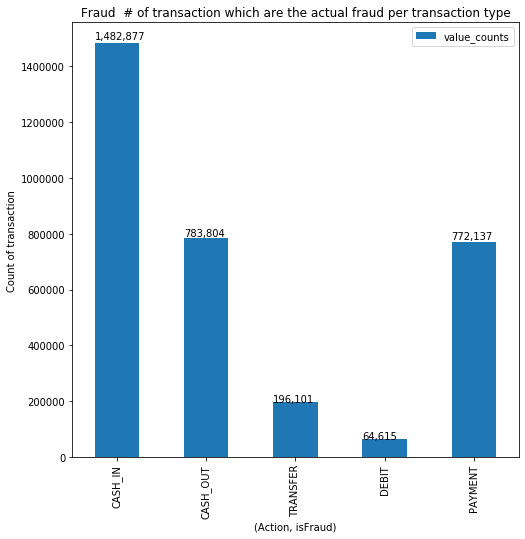

In [15]:
%%local
%matplotlib inline 
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = fraud_action_counts.plot(x='action', y='value_counts' , kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Action, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

plt.show()    

#df.loc[(action_counts.fraud == True), :]
f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = valid_action_counts.plot(x='action', y='value_counts' , kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
ax.set_title("Fraud  # of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Action, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))
    
plt.show()    

In [16]:
fraud_transfers = df.where(func.col('action')=='TRANSFER').where(func.col("label")==1)
valid_transfers = df.where(func.col('action')=='TRANSFER').where(func.col("label")==0)

In [17]:
fraud_cash_out = df.where(func.col('action')=='CASH_OUT').where(func.col("label")==1)
valid_cash_out = df.where(func.col('action')=='CASH_OUT').where(func.col("label")==0)

In [18]:
%%spark -o fraud_transfers

In [19]:
%%spark -o valid_transfers

In [20]:
%%spark -o fraud_cash_out

In [21]:
%%spark -o valid_cash_out

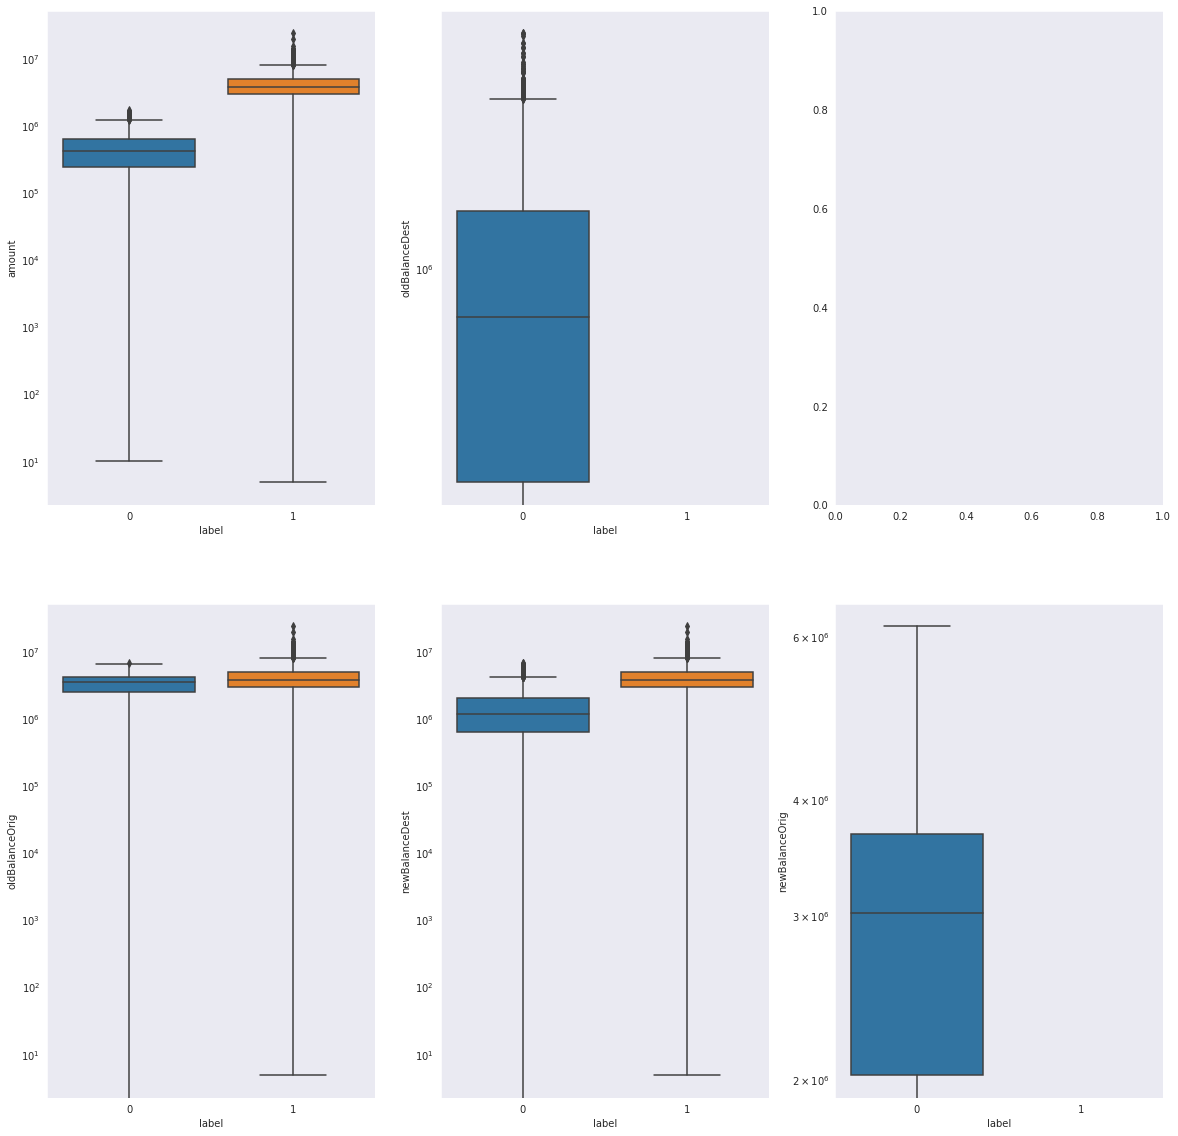

In [22]:
%%local
import seaborn as sns
import pandas as pd
sns.set_style("dark")

transfers = pd.concat([fraud_transfers, valid_transfers])

fig, axs = plt.subplots(2, 3, figsize=(20, 20))
a = sns.boxplot(x = 'label', y = 'amount', data = transfers, ax=axs[0][0])
axs[0][0].set_yscale('log')

b = sns.boxplot(x = 'label', y = 'oldBalanceDest', data = transfers, ax=axs[0][1])
axs[0][1].set_yscale('log')

c = sns.boxplot(x = 'label', y = 'oldBalanceOrig', data=transfers, ax=axs[1][0])
axs[1][0].set_yscale('log')

d = sns.boxplot(x = 'label', y = 'newBalanceDest', data = transfers, ax=axs[1][1])
axs[1][1].set_yscale('log')

f = sns.boxplot(x = 'label', y = 'newBalanceOrig', data=transfers, ax=axs[1][2])
axs[1][2].set_yscale('log')
plt.show()

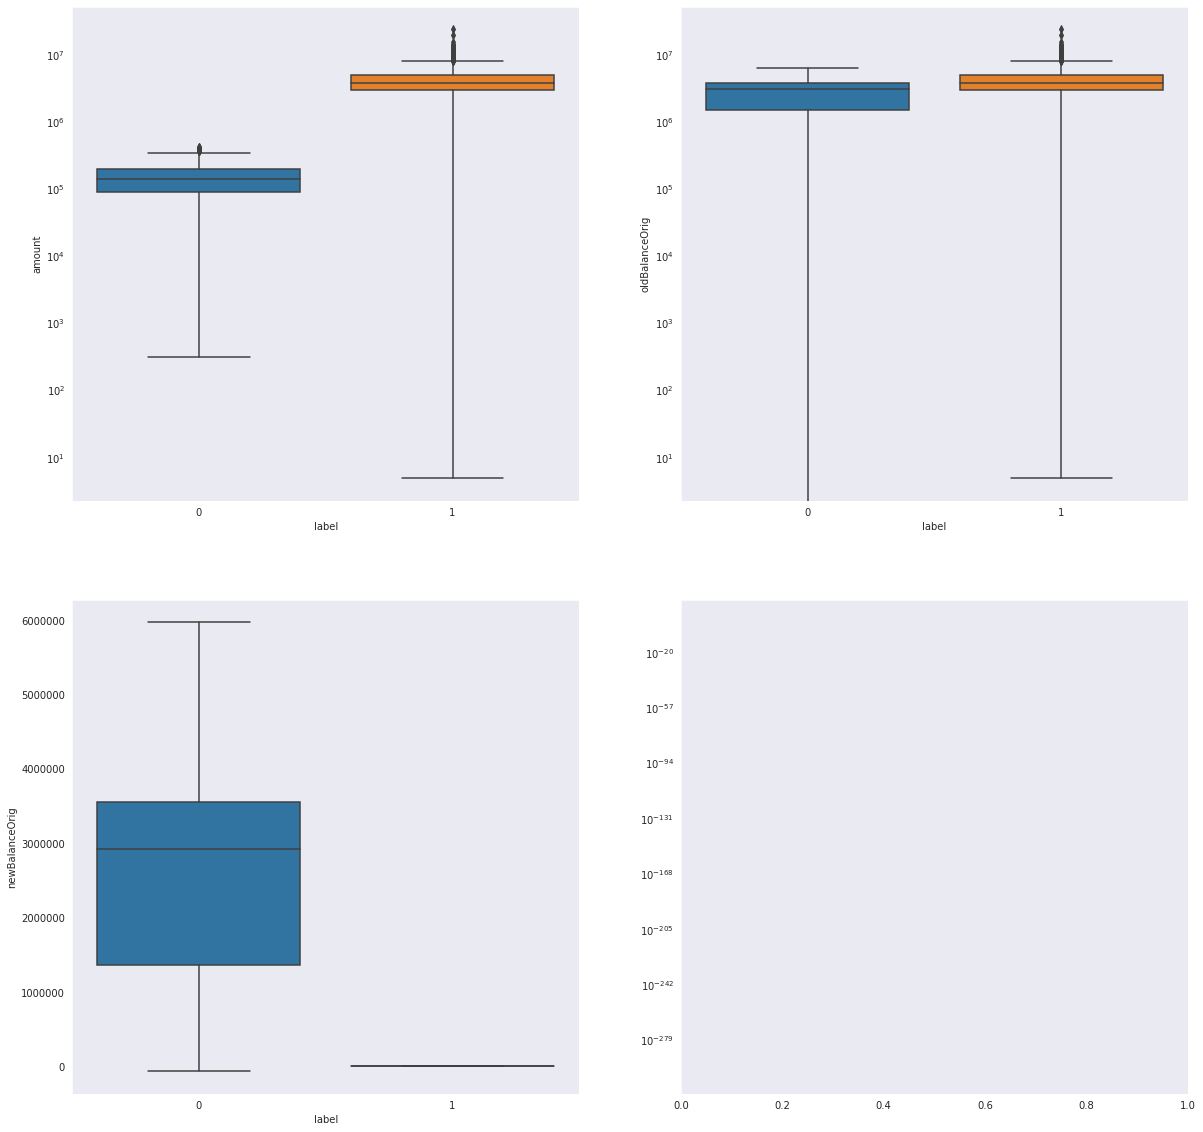

In [23]:
%%local

cash_out = pd.concat([fraud_cash_out, valid_cash_out])

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
a = sns.boxplot(x = 'label', y = 'amount', data=cash_out, ax=axs[0][0])
axs[0][0].set_yscale('log')

b = sns.boxplot(x = 'label', y = 'oldBalanceOrig', data=cash_out, ax=axs[0][1])
axs[0][1].set_yscale('log')

c = sns.boxplot(x = 'label', y = 'newBalanceOrig', data=cash_out, ax=axs[1][0])
axs[1][1].set_yscale('log')#.set(ylim=(0, 3e7))
plt.show()

### Rule based system


In [33]:
# Rules to Identify Known Fraud-based
from pyspark.sql import functions as F
df = df.withColumn("rules_label", 
                   F.when(
                     ((df.oldBalanceOrig <= 60000) & (df.action == "TRANSFER") & (df.newBalanceDest <= 90)) |  ((df.oldBalanceOrig > 60000) & (df.newBalanceOrig <= 100)) , 1
                   ).otherwise(0))

In [34]:
df.select("label","rules_label").show()

+-----+-----------+
|label|rules_label|
+-----+-----------+
|    1|          1|
|    1|          0|
|    0|          0|
|    0|          0|
|    0|          0|
|    0|          0|
|    0|          0|
|    0|          0|
|    0|          0|
|    0|          0|
|    0|          0|
|    0|          0|
|    0|          0|
|    0|          0|
|    0|          0|
|    0|          0|
|    0|          0|
|    0|          0|
|    0|          0|
|    0|          0|
+-----+-----------+
only showing top 20 rows

In [35]:
df.where((func.col("label")==0) & (func.col("rules_label")==1)).count()

701

In [36]:
df.where((func.col("label")==1) & (func.col("rules_label")==0)).count()

4

In [37]:
df.where((func.col("label")==1) & (func.col("rules_label")==1)).count()

1430

In [38]:
df.where((func.col("label")==1)).count()

1434

In [39]:
df.where((func.col("label")==0) & (func.col("rules_label")==0)).count()

3298833